# Image_Recoloring using LEARNED PERCEPTUAL IMAGE PATCH SIMILARITY (LPIPS)_5K

In [ ]:
pip install lpips

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 6.4 MB/s eta 0:00:00


In [ ]:
pip install torchmetrics[image]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 32.2 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import os
from tqdm import tqdm
import torchvision.datasets as datasets
from PIL import Image
import glob
from torch.utils.data import DataLoader,Dataset
import time as time
from IPython import display
from torchvision.utils import make_grid
import torchvision.models as models
import torch.nn.functional as F
from scipy import linalg
import cv2
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset
from torch import nn
import zipfile
from google.colab import drive
from torchvision import transforms
import torchvision.datasets as datasets
from torch import nn
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import torchvision.utils
from torchvision.models import inception_v3
from torchvision.transforms import Resize
import lpips
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity
import pickle

# Imagenet Dataset


##Dowmload Dataset

The dataset is shared here https://drive.google.com/file/d/1miE6-MmvB4xpYzxVfWqR7xttekCjQr3O/view?usp=sharing . Add a shortcut to your own google drive and mount drive on google colab. this way you should be able to access the dataset

In [ ]:
#Using imageNet_Mini dataset => subset of imageNet dataset (around 30,000 images)
#this datset already uploaded in driver and this part to install it from driver
drive.mount('/content/drive')

!cp "/content/drive/My Drive/imageNet_Mini.zip" "imageNet_Mini.zip"

with zipfile.ZipFile('imageNet_Mini.zip', 'r') as zip_ref:
    zip_ref.extractall('imageNet_Mini')

Mounted at /content/drive


##*ImageDataset* Class

In [ ]:
#define ImageDataset class to deal with the dataset
class ImageDataset(datasets.ImageFolder):
    def __init__(self,root,transform,target_transform):
      super().__init__(root,transform,target_transform)
      self.root = root

    #The __len__ function returns the number of samples in our dataset.
    def __len__(self):
      return len(self.samples)

    #Use  __getitem__ function to reatch spetail items by indexes
    #This function return 2 images (sample,target) with spetial transform for everyone
    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is our original image .
        """
        path, target = self.samples[index]
        sample = self.loader(path)

        if self.transform is not None:
            sample1 = self.transform(sample)

        if self.target_transform is not None:
            target = self.target_transform(sample)

        return sample1,target

##Define Transforms

In [ ]:
#Define new size for images 256X256
SIZE = 256
# for normalization => gray = (0.2989 * red + 0.587 * green + 0.114 * blue) Mean: 0.445 Standard Deviation: 0.269

#image_transform used to convert orignial images (colored) to grayscale, resize them to 256x256, convert it to tensor, and normalize the images
image_transform = transforms.Compose([
                        transforms.Grayscale(),
                        transforms.Resize([SIZE, SIZE]),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.5],
                                 std=[0.5])
                        ])

#target_transform used to resize the colored images to 256x256, convert them to tensor, and normalize the images
target_transform = transforms.Compose([
                        transforms.Resize([SIZE, SIZE]),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                        std=[0.5, 0.5, 0.5])
                        ])

##Create the Dataset using ImangeDataset class & Transforms

In [ ]:
#Define train_dataset and test_dataset objects and implement the transforms
train_dataset = ImageDataset('imageNet_Mini/imagenet-mini/train',
                        transform = image_transform,
                        target_transform = target_transform)

test_dataset = ImageDataset('imageNet_Mini/imagenet-mini/val',
                        transform = image_transform,
                        target_transform = target_transform)

In [ ]:
#split train_dataset to 85% train dataset and 15% validation dataset
train_dataset1,_ =torch.utils.data.random_split(train_dataset,(6000,28745))
train_dataset_len = len(train_dataset1)
train_length = int( 0.85 * train_dataset_len)

validation_length = train_dataset_len - train_length
train_dataset,validation_dataset=torch.utils.data.random_split(train_dataset1,(train_length,validation_length))
test_dataset,_ =torch.utils.data.random_split(test_dataset,(1000,2923))

###Plot the dataset

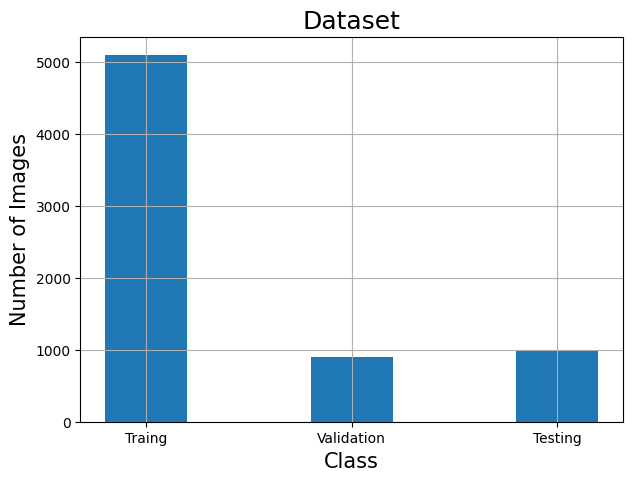

In [ ]:
train_length = train_dataset.__len__()
validation_length = validation_dataset.__len__()
test_length = test_dataset.__len__()

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot()
plt.title('Dataset', size=18)
plt.bar([1, 2, 3], [train_length, validation_length, test_length], width=.4)
ax.set_xlabel('Class', size=15)
ax.set_ylabel('Number of Images', size=15)
plt.xticks([1,2,3], ['Traing', 'Validation', 'Testing'])
plt.grid()
plt.show()

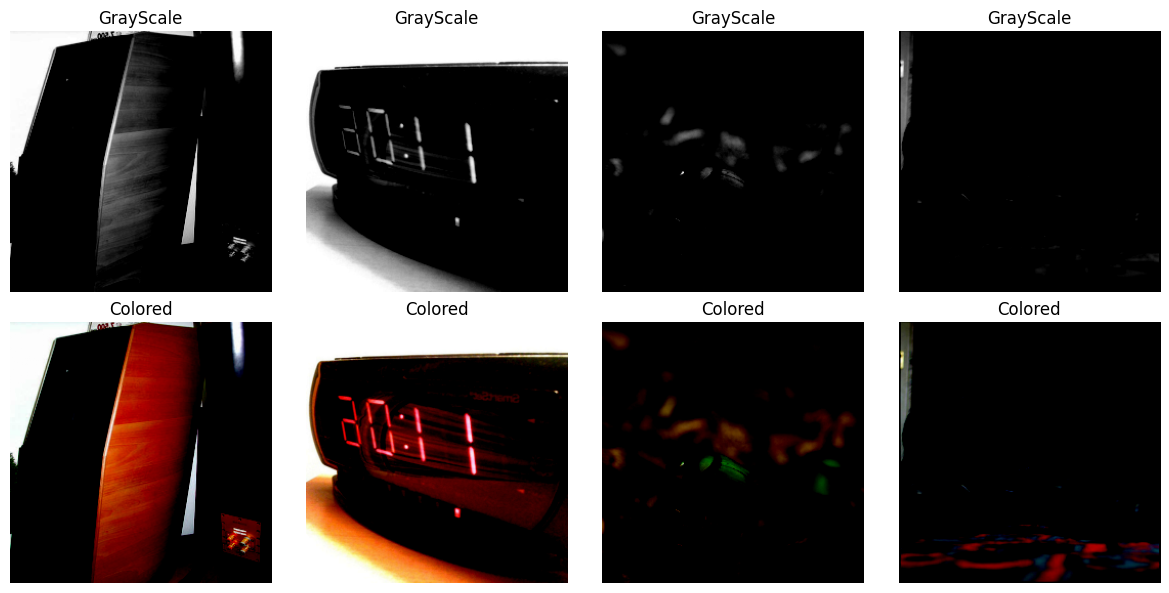

In [ ]:
# Plot some images from the dataset
image_inds = np.random.choice(test_dataset.__len__(), 16, replace=False)
lab_batch = torch.stack([test_dataset[i][0] for i in image_inds])
original = torch.stack([test_dataset[i][1] for i in image_inds])
fig, axs = plt.subplots(2,4, figsize=(12, 6))

for i in range(4):

  #Grayscale images
  img = np.rot90(np.array(lab_batch[i].cpu()).squeeze().transpose(),k=3)
  img = np.clip(img, 0, 1)
  axs[0, i].imshow(img, cmap='gray')
  axs[0, i].set_title('GrayScale')
  axs[0, i].axis('off')

  # Original images
  img = np.rot90(np.array(original[i].cpu()).squeeze().transpose(),k=3)
  img = np.clip(img, 0, 1)
  axs[1, i].imshow(img)
  axs[1, i].set_title('Colored')
  axs[1, i].axis('off')

plt.tight_layout()
plt.show()

# Discriminator Model

In [ ]:
#Create Discriminator Model

#Define conv_block_WOBN function to create convolution layer with LeakyReLU activation function
def conv_block_WOBN(in_channel,out_channel,stride):
  conv = nn.Sequential(
     nn.Conv2d(in_channel,out_channel,kernel_size=4,stride=stride, padding=1,bias=False,padding_mode="reflect"),
     nn.LeakyReLU(.2),
  )
  return conv

#Define conv_block function to create convolution layer with BatchNorm2d and LeakyReLU activation function
def conv_block(in_channel,out_channel,stride):
  conv = nn.Sequential(
     nn.Conv2d(in_channel,out_channel,kernel_size=4,stride=stride, padding=1,bias=False,padding_mode="reflect"),
     nn.BatchNorm2d(out_channel),
     nn.LeakyReLU(.2),
  )
  return conv

#Define conv_block_WS function to create convolution layer without BatchNorm2d as last layer
def conv_block_WS(in_channel,out_channel,stride):
  conv = nn.Sequential(
     nn.Conv2d(in_channel,out_channel,kernel_size=4,stride=stride, padding=1,bias=False,padding_mode="reflect"),
  )
  return conv

#Create Discriminator class
class Discriminator(nn.Module):

  def __init__(self):
    super().__init__()

    self.down_conv1=conv_block_WOBN(4,64,2)
    self.down_conv2=conv_block(64,128,2)
    self.down_conv3=conv_block(128,256,2)
    self.down_conv4=conv_block(256,512,1)
    self.down_conv5=conv_block_WS(512,1,1)

  def forward(self,x1,y1):

    x = torch.cat([x1, y1],1)
    x=self.down_conv1(x)
    x=self.down_conv2(x)
    x=self.down_conv3(x)
    x=self.down_conv4(x)
    x=self.down_conv5(x)

    #simoid activation function in output
    x = torch.sigmoid(x)

    return x

In [ ]:
#for testing the Discriminator model
model = Discriminator ()
def test(x,y):
  x1 = torch.randn((1,3,x,y))
  y1 = torch.randn((1,1,x,y))
  predict=model(x1,y1)
  print(predict.shape)

test(256,256)

torch.Size([1, 1, 30, 30])


In [ ]:
print(model)

Discriminator(
  (down_conv1): Sequential(
    (0): Conv2d(4, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (down_conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (down_conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (down_conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=reflect)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=

# Generator Model

In [ ]:
#For create Generator model
#Define conv_block_WOBN function to create convolution layer with LeakyReLU or ReLU activation function
def conv_block_WOBN(in_channel,out_channel,act1):
  conv = nn.Sequential(
     nn.Conv2d(in_channel,out_channel,kernel_size=4,stride=2, padding=1,bias=False,padding_mode="reflect"),
     nn.ReLU() if act1 ==  "relu" else nn.LeakyReLU(.2)
  )
  return conv

#Define conv_block function to create convolution layer with LeakyReLU or ReLU activation function with BatchNorm2d
def conv_block(in_channel,out_channel,act1):
  conv = nn.Sequential(
     nn.Conv2d(in_channel,out_channel,kernel_size=4,stride=2, padding=1,bias=False,padding_mode="reflect"),
     nn.BatchNorm2d(out_channel),
     nn.ReLU() if act1 ==  "relu" else nn.LeakyReLU(.2)
  )
  return conv

#Define dconv_block function to create Deconvolution layer with ReLU activation function with BatchNorm2d
def dconv_block(in_channel,out_channel):
  conv = nn.Sequential(
     nn.ConvTranspose2d(in_channel,out_channel,kernel_size=4,stride=2, padding=1,bias=False),
     nn.BatchNorm2d(out_channel),
     nn.ReLU(),
  )
  return conv

#create Generator class
class Generator(nn.Module):

  def __init__(self):
    super().__init__()

    self.down_conv1=conv_block_WOBN(1,64,act1="leaky")
    self.down_conv2=conv_block(64,128,act1="leaky")
    self.down_conv3=conv_block(128,256,act1="leaky")
    self.down_conv4=conv_block(256,512,act1="leaky")
    self.down_conv5=conv_block(512,512,act1="leaky")
    self.down_conv6=conv_block(512,512,act1="leaky")
    self.down_conv7=conv_block(512,512,act1="leaky")
    self.down_conv8=conv_block(512,512,act1="relu")

    self.up_conv1=dconv_block(512,512)
    self.up_conv2=dconv_block(512*2,512)
    self.up_conv3=dconv_block(512*2,512)
    self.up_conv4=dconv_block(512*2,512)
    self.up_conv5=dconv_block(512*2,256)
    self.up_conv6=dconv_block(256*2,128)
    self.up_conv7=dconv_block(128*2,64)

    self.dropout=nn.Dropout(.5)

    self.out=nn.Sequential(
        nn.ConvTranspose2d(64*2,3,kernel_size=4,stride=2, padding=1),
        #use tanh as output activiation function
        nn.Tanh(),
    )

  def forward(self,image):

    x1=self.down_conv1(image)
    x2=self.down_conv2(x1)
    x3=self.down_conv3(x2)
    x4=self.down_conv4(x3)
    x5=self.down_conv5(x4)
    x6=self.down_conv6(x5)
    x7=self.down_conv7(x6)

    x8=self.down_conv8(x7)
    x=self.up_conv1(x8)
    x=self.dropout(x)

    x=self.up_conv2(torch.cat([x, x7],1))
    x=self.dropout(x)
    x=self.up_conv3(torch.cat([x, x6],1))
    x=self.dropout(x)
    x=self.up_conv4(torch.cat([x, x5],1))
    x=self.up_conv5(torch.cat([x, x4],1))
    x=self.up_conv6(torch.cat([x, x3],1))
    x=self.up_conv7(torch.cat([x, x2],1))

    x=self.out(torch.cat([x, x1],1))

    return x

In [ ]:
#For testing the model
model = Generator()
def test(x,y):
  x1 = torch.randn((1,1,x,y))
  #y1 = torch.randn((1,3,x,y))
  predict=model(x1)
  print(predict.shape)

test(512,512)

torch.Size([1, 3, 512, 512])


In [ ]:
print(model)

Generator(
  (down_conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (down_conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (down_conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (down_conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)

# Evaluation Matrices

##Fretchet Inception Distance (FID)

In [ ]:
#Fretchet Inception Distance
#FID is a more principled and comprehensive metric and has been shown to be more consistent with human evaluation in assessing the realism
#and variation of the generated samples.
#Lower FID means better quality and diversity.
#reference
  #https://www.kaggle.com/code/ibtesama/gan-in-pytorch-with-fid

#Define InceptionV3
class InceptionV3(nn.Module):

    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):

        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()


        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp

block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
inceptionV3_model = InceptionV3([block_idx])
#model=model.cuda()
#inceptionV3_model = inceptionV3_model.to(device)

################
def calculate_activation_statistics(images,model,batch_size=128, dims=2048,
                    cuda=False):
    model.eval()
    act=np.empty((len(images), dims))

    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)

    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma



def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):

    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2


    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))


    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)


def calculate_fretchet(images_real,images_fake,model):
     mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=True)
     mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=True)

     """get fretched distance"""
     fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
     return fid_value

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:02<00:00, 37.3MB/s]


 ## Inception Score (IS)

In [ ]:
##### Inception Score
def calculate_inception_score(images, batch_size=32, device='cuda'):
    # Load the InceptionV3 model
    inception_model = inception_v3(pretrained=True, transform_input=False)
    inception_model.to(device)
    inception_model.eval()

    # Prepare the images
    transform = Resize((299, 299))  # Resize the images to a fixed size (e.g., 299x299)
    images = torch.stack([transform(image) for image in images]).to(device)

    # Generate predictions
    preds = []
    num_batches = (len(images) - 1) // batch_size + 1

    with torch.no_grad():
        for i in range(num_batches):
            batch = images[i * batch_size : (i + 1) * batch_size]
            pred = inception_model(batch)
            preds.append(F.softmax(pred, dim=1).cpu().numpy())

    preds = np.concatenate(preds, axis=0)

    # Calculate Inception Score
    kl_divergences = preds * (np.log(preds) - np.log(preds.mean(axis=0)))
    kl_divergences = kl_divergences.sum(axis=1)
    inception_score = np.exp(np.mean(kl_divergences))

    return inception_score

##Peak Signal-to-Noise Ratio (PSNR) & Structural Similarity Index (SSIM)

In [ ]:
#PSNR , SSIM
def compute_psnr_ssim(real_images, generated_images):
    # Compute PSNR
    psnr_values = []
    for real, generated in zip(real_images, generated_images):
        psnr_value = psnr(real.permute(1, 2, 0).cpu().numpy(), generated.permute(1, 2, 0).cpu().numpy(), data_range=1.0)
        psnr_values.append(psnr_value)

    # Compute SSIM
    ssim_values = []
    for real, generated in zip(real_images, generated_images):
        ssim_value = ssim(real.permute(1, 2, 0).cpu().numpy(), generated.permute(1, 2, 0).cpu().numpy(), data_range=1.0,channel_axis=2)
        ssim_values.append(ssim_value)

    return psnr_values, ssim_values

def compute_average(values):
    tensor_values = torch.Tensor(values)
    return torch.mean(tensor_values)

##Mean Absolute Error (MAE)

In [ ]:
# Mean Absolute Error (MAE) metric
def compute_mae(real_images, generated_images):
    # Compute MAE
    absolute_errors = torch.abs(real_images - generated_images)
    mae_values = torch.mean(absolute_errors, dim=(1, 2, 3))
    return mae_values

def compute_average(values):
  tensor_values = torch.Tensor(values)
  return torch.mean(tensor_values)

## Main Evaluation Function

In [ ]:
# Create evaluation_metrics function to perform previous metrics
#this function take dataset for example test or validation dataset and number of images you want to test them
#this function return FID,IS_real,IS_generated,psnr,ssim,MAE as avarge values
#gen = Generator()

def evaluation_metrics(dataset,samples_num,inceptionV3_model):

  gen.eval()
  with torch.no_grad():
    # Set a different random seed each time
    np.random.seed()
    image_inds = np.random.choice(dataset.__len__(), samples_num, replace=False)
    lab_batch = torch.stack([dataset[i][0] for i in image_inds])
    lab_batch = lab_batch.to(device)
    original = torch.stack([dataset[i][1] for i in image_inds])

    predictions = gen(lab_batch).detach().cpu()

  FID = calculate_fretchet(original,predictions, inceptionV3_model)

  IS_real = calculate_inception_score(original)
  IS_generated = calculate_inception_score(predictions)

  psnr_values, ssim_values = compute_psnr_ssim(original, predictions)
  psnr = compute_average(psnr_values)
  ssim = compute_average(ssim_values)

  mae_values = compute_mae(original, predictions)
  MAE = compute_average(mae_values)

  return FID,IS_real,IS_generated,psnr,ssim,MAE

# Trainig

## Data Loader

In [ ]:
#Define Train Data-loader with batch size = 16
BATCH_SIZE=16
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

#Define Validation Data-loader with batch size = 16
validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

#Define test Data-loader with batch size = 16
test_dataloader = DataLoader(
    test_dataset,
     batch_size=BATCH_SIZE,
      shuffle=False,
      )

batch_data,batch_labels= next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels_Length: {len(batch_labels)}")

batch_data,batch_labels= next(iter(validation_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels_Length: {len(batch_labels)}")

batch_data,batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels_Length: {len(batch_labels)}")

TRAIN BATCH SHAPE
	 Data: torch.Size([16, 1, 256, 256])
	 Labels_Length: 16
TRAIN BATCH SHAPE
	 Data: torch.Size([16, 1, 256, 256])
	 Labels_Length: 16
TEST BATCH SHAPE
	 Data: torch.Size([16, 1, 256, 256])
	 Labels_Length: 16


##Initial weights for the model

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        #nn.init.xavier_uniform_(m.weight.data)
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        #nn.init.xavier_uniform_(m.weight.data)
    elif classname.find('BatchNorm') != -1:
        #nn.init.normal_(m.weight.data, 1.0, 0.2)
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Discriminator Loss Function

In [ ]:
#define Binary Cross Entropy Los
BCE_loss = nn.BCELoss()

#define discriminator_loss function = > this function return the total loss between real loss and fake loss devided by 2
def discriminator_loss(D_real, D_fake, device):

   #compute BCE_loss between D_real which represents the discriminator's output for real images,
    #the target is torch.ones_like which is a tensor of ones with the same shape as D_real
    real_loss = BCE_loss(D_real, torch.ones_like(D_real, device=device))

    #compute BCE_loss between D_fake which represents the discriminator's output for generated or fake images,
    #the target is torch.zeros_like which is a tensor of ones with the same shape as D_fake
    fake_loss = BCE_loss(D_fake, torch.zeros_like(D_fake, device=device))

    #compute the total loss as sum of 2 losses => real_loss + fake_loss devided by 2
    total_loss = (real_loss + fake_loss)/2
    #total_loss = (real_loss + fake_loss)
    return total_loss


## Generator Loss Function

In [ ]:
#lpips is a perceptual similarity metric used for evaluating image quality.
#It measures the similarity between two images based on their perceptual features, which are extracted using a pre-trained neural network

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#lpips_model.to(device)

#define Binary Cross Entropy Loss
BCE_loss = nn.BCELoss()

#define l1 loss
l1_loss = nn.L1Loss()

#define l1 as a hyper parameter
Lambda = 100

#define generator_loss to compute generator loss and return the total loss as a result
def generator_loss(g_image,color_image , fake_out, device):

    #compute BCE_loss between fake_out which represents the discriminator's output for generated or fake images,
    #the target is torch.ones_like which is a tensor of ones with the same shape as fake_out
    BCE_gen_loss = BCE_loss(fake_out, torch.ones_like(fake_out, device=device))

    #compute l1 loss between generated images and original colored one and multiply it with lambda (100 in our case)
    L1 = l1_loss(g_image, color_image) * Lambda

    #compute lpips_loss
    lpips_loss = lpips_model (g_image,color_image)

    #compute the total loss as sum of 3 losses => BCE_gen_loss + L1 + lpips_loss
    gen_loss = BCE_gen_loss + L1 + lpips_loss

    return gen_loss

## Networks Parameters

In [ ]:
#define disc object from Discriminator class and apply the initial weights
disc = Discriminator()
disc.apply(weights_init)

#define gen object from Generator class and apply the initial weights
gen = Generator()
gen.apply(weights_init)

#defie learning rate lr = 2e-4
lr = 2e-4

#defne 2 optimizer one for gentator and one for discriminator
optim_disc = torch.optim.Adam(disc.parameters() , lr=lr , betas=(.5,.999))
optim_gen = torch.optim.Adam(gen.parameters() , lr=lr , betas=(.5,.999))

#optim_disc = torch.optim.Adam(disc.parameters() , lr=lr)
#optim_gen = torch.optim.Adam(gen.parameters() , lr=lr )

lpips_model = LearnedPerceptualImagePatchSimilarity(reduction='mean',normalize=False ,net_type='vgg')

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 157MB/s]


Selected device: cuda


## Training Function

In [ ]:
#define training step with losses
#this function return 2 losses one for generator and one for discriminator
def train_step(gray_image,color_image, generator, discriminator, BATCH_SIZE, device, optim_disc, optim_gen):

    #set the networks in training mode
    generator.train()
    discriminator.train()

    ####### discriminator loss

    #generate new image using generator model
    g_image = generator(gray_image)

    #use discriminator network between gray image and original colored one
    real_out = discriminator(gray_image, color_image)

    #use discriminator network between gray image and generated colored one by generator network
    fake_out = discriminator(gray_image,g_image.detach())

    #compute discriminator loss by calling discriminator_loss function between real output and fake output
    disc_loss = discriminator_loss(real_out, fake_out, device)

    #set the gradients of all parameters of a discriminator optimizer to zero.
    optim_disc.zero_grad()

    #perform backpropagation with respect to a given loss.
    disc_loss.backward()

    #update discriminator optimizer
    optim_disc.step()

    ####### generator loss
    fake_out = discriminator(gray_image,g_image)

    #compute generator loss by calling generator_loss function between real output and fake putput
    gen_loss = generator_loss(g_image,color_image , fake_out, device)

    #set the gradients of all parameters of a genertor optimizer to zero.
    optim_gen.zero_grad()

    #perform backpropagation in generator with respect to a given loss.
    gen_loss.backward()

    #update generator optimizer
    optim_gen.step()

    return gen_loss, disc_loss

##Testing Function

In [ ]:
#define test function for validation and test stages
#we compute the losses as in previous stage but without backpropagation
#here we put the network in evaluation mode
#this function return generator ans critic losses
def test_epoch(gray_image,color_image, generator, discriminator, BATCH_SIZE, device):

    generator.eval()
    discriminator.eval()

    with torch.no_grad():

      g_image = generator(gray_image)
      real_out = discriminator(gray_image, color_image)
      fake_out = discriminator(gray_image,g_image.detach())

      disc_loss = discriminator_loss(real_out, fake_out, device)
      gen_loss = generator_loss(g_image,color_image , fake_out, device)

    return gen_loss, disc_loss

##Plot Images

In [ ]:
#this function to plot the images as grayscale, generated and original one
def generate_and_save_images(gen, epoch, gray_image,colored_image,x,num_of_rows):

  #Set the generator in evaluation mode.
  gen.eval()

  #Disable gradient calculation
  with torch.no_grad():
      #save the generated image in predictions variable
      predictions = gen(gray_image).detach().cpu()

  fig, axs = plt.subplots(num_of_rows, 3, figsize=(12, num_of_rows*4))

  for i in range(num_of_rows):

    if num_of_rows == 1 :

      # Gray images
      img = np.rot90(np.array(gray_image[i].cpu()).squeeze().transpose(),k=3)
      img = np.clip(img, 0, 1)
      axs[0].imshow(img, cmap='gray')
      axs[0].set_title('{} - Input'.format(x))
      axs[0].axis('off')

      # Generated images
      img = np.rot90(np.array(predictions[i].cpu()).squeeze().transpose(),k=3)
      img = np.clip(img, 0, 1)
      axs[1].imshow(img)
      axs[1].set_title('{} - Generated'.format(x))
      axs[1].axis('off')

      # Original images
      img = np.rot90(np.array(colored_image[i].cpu()).squeeze().transpose(),k=3)
      img = np.clip(img, 0, 1)
      axs[2].imshow(img)
      axs[2].set_title('{} - Real'.format(x))
      axs[2].axis('off')

    else :

      img = np.rot90(np.array(gray_image[i].cpu()).squeeze().transpose(),k=3)
      img = np.clip(img, 0, 1)
      axs[i, 0].imshow(img, cmap='gray')
      axs[i, 0].set_title('{} - Input'.format(x))
      axs[i, 0].axis('off')

      # Generated images
      img = np.rot90(np.array(predictions[i].cpu()).squeeze().transpose(),k=3)
      img = np.clip(img, 0, 1)
      axs[i, 1].imshow(img)
      axs[i, 1].set_title('{} - Generated'.format(x))
      axs[i, 1].axis('off')

      # Original images
      img = np.rot90(np.array(colored_image[i].cpu()).squeeze().transpose(),k=3)
      img = np.clip(img, 0, 1)
      axs[i, 2].imshow(img)
      axs[i, 2].set_title('{} - Real'.format(x))
      axs[i, 2].axis('off')

  plt.tight_layout()
  #plt.show()

  #To save the images
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

##Network Training  & Testing using Validation dataset

In [ ]:
g_gen_losses = []
g_disc_losses = []
g_gen_losses_val = []
g_disc_losses_val = []

FID_val = []
MAE_val = []
PSNR_val = []
SSIM_val = []
IS_real_val = []
IS_generated_val = []

disc.to(device)
gen.to(device)
inceptionV3_model.to(device)
lpips_model.to(device)

LearnedPerceptualImagePatchSimilarity(
  (net): NoTrainLpips(
    (scaling_layer): ScalingLayer()
    (net): vgg16(
      (slice1): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
      (slice2): Sequential(
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace=True)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace=True)
      )
      (slice3): Sequential(
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace=True)
        (12): Conv2d(256, 256, kernel_size=(3, 

In [ ]:
#set the number of EPOCHS for training
previous_epochs = 250
EPOCHS = 100

for epoch in range(EPOCHS):

  start = time.time()
  gen_losses = []
  disc_losses = []
  gen_losses_val = []
  disc_losses_val = []

######################################################## Training #####################################################################
  #training using train_dataloader
  for gray_image,colored_image in train_dataloader:

    colored_image = colored_image.to(device)
    gray_image = gray_image.to(device)

    #compute the losses using train_step function
    gen_loss, disc_loss = train_step(gray_image,colored_image, gen, disc, BATCH_SIZE, device, optim_disc, optim_gen)

    #save the losses in array
    gen_losses.append(gen_loss.detach().cpu())
    disc_losses.append(disc_loss.detach().cpu())

  g_gen_losses.append(np.mean(gen_losses))
  g_disc_losses.append(np.mean(disc_losses))

  #print the losses
  print ('Time for epoch {} is {} sec'.format(previous_epochs + epoch + 1, time.time()-start))
  print('\n\t partial train loss for Discriminator (single batch): %f' % (np.mean(disc_losses)))
  print('\t partial train loss for Generator (single batch): %f' % (np.mean(gen_losses)))

  ##Show some images
  generate_and_save_images(gen, epoch+1, gray_image,colored_image,"Training",num_of_rows=1)

######################################################## Validation #####################################################################
 #testing using validation_dataloader
  if  ((epoch+1) %  10 == 0):

    for gray_image,colored_image in validation_dataloader:

      colored_image = colored_image.to(device)
      gray_image = gray_image.to(device)

      #compute the losses using test_epoch function
      gen_loss, disc_loss = test_epoch(gray_image,colored_image, gen, disc, BATCH_SIZE, device)

      #save the losses in array
      gen_losses_val.append(gen_loss.detach().cpu())
      disc_losses_val.append(disc_loss.detach().cpu())

    g_gen_losses_val.append(np.mean(gen_losses_val))
    g_disc_losses_val.append(np.mean(disc_losses_val))

    #print the losses
    print ('Time for epoch {} is {} sec'.format(previous_epochs + epoch + 1, time.time()-start))
    print('\n\t Partial validation loss for Discriminator (single batch): %f' % (np.mean(disc_losses_val)))
    print('\t Partial validation loss for Generator (single batch): %f' % (np.mean(gen_losses_val)))

    #################################################### Evaluation Metrics ##############################################################
    # call evaluation_metrics to perfrom the evaluation on validation dataset
    np.random.seed()
    FID,IS_real,IS_generated,PSNR,SSIM,MAE = evaluation_metrics(validation_dataset,200,inceptionV3_model)

    FID_val.append(FID)
    IS_real_val.append(IS_real)
    IS_generated_val.append(IS_generated)
    PSNR_val.append(PSNR)
    SSIM_val.append(SSIM)
    MAE_val.append(MAE)

    print("\n\t Partial validation evaluation using FID for 200 validation samples:", f"{FID:.2f}")
    print("\t Partial validation evaluation using IS for 200 validation samples for real images:", f"{IS_real:.2f}")
    print("\t Partial validation evaluation using IS for 200 validation samples for generated images:", f"{IS_generated:.2f}")
    print("\t Partial validation evaluation using PSNR for 200 validation samples:", f"{PSNR.item():.2f}")
    print("\t Partial validation evaluation using SSIM for 200 validation samples:", f"{SSIM.item():.2f}")
    print("\t Partial validation evaluation using MAE for 200 validation images:",f"{MAE.item():.2f}")

    #Show some images
    generate_and_save_images(gen, epoch+1, gray_image,colored_image,"Validation",num_of_rows=4)

#Save Netwroks & Optimizers

In [ ]:
# Save network parameters
torch.save(gen.state_dict(), 'gen_params1_PL_5K_350.pth')
torch.save(disc.state_dict(), 'disc_params1_PL_5K_350.pth')

In [ ]:
# Save optimizers
torch.save(optim_gen.state_dict(), 'optim_gen1_PL_5K_350.pth')
torch.save(optim_disc.state_dict(), 'optim_disc1_PL_5K_350.pth')

In [ ]:
# Create a dictionary to hold the lists
data = {
    'g_gen_losses': g_gen_losses,
    'g_disc_losses': g_disc_losses,
    'g_gen_losses_val': g_gen_losses_val,
    'g_disc_losses_val': g_disc_losses_val,
    'FID_val': FID_val,
    'MAE_val': MAE_val,
    'PSNR_val': PSNR_val,
    'SSIM_val': SSIM_val,
    'IS_real_val': IS_real_val,
    'IS_generated_val': IS_generated_val
}


# Save the dictionary to a file
with open('lists1_PL_5K_350.pkl', 'wb') as f:
    pickle.dump(data, f)


#Load Netwroks & Optimizers

In [ ]:
# Load network parameters

!cp "/content/drive/My Drive/gen_params1_PL_5K_350.pth" "gen_params1_PL_5K_350.pth"
gen.load_state_dict(torch.load('gen_params1_PL_5K_350.pth'))

!cp "/content/drive/My Drive/disc_params1_PL_5K_350.pth" "disc_params1_PL_5K_350.pth"
disc.load_state_dict(torch.load('disc_params1_PL_5K_350.pth'))

<All keys matched successfully>

In [ ]:
#Load optimizers
lr = 2e-4

#defne 2 optimizer one for gentator and one for discriminator
optim_disc = torch.optim.Adam(disc.parameters() , lr=lr , betas=(.5,.999))
!cp "/content/drive/My Drive/optim_disc1_PL_5K_350.pth" "optim_disc1_PL_5K_350.pth"
optim_disc.load_state_dict(torch.load('optim_disc1_PL_5K_350.pth'))

optim_gen = torch.optim.Adam(gen.parameters() , lr=lr , betas=(.5,.999))
!cp "/content/drive/My Drive/optim_gen1_PL_5K_350.pth" "optim_gen1_PL_5K_350.pth"
optim_gen.load_state_dict(torch.load('optim_gen1_PL_5K_350.pth'))

In [ ]:
# Load the dictionary from the file
!cp "/content/drive/My Drive/lists1_PL_5K_350.pkl" "lists1_PL_5K_350.pkl"

with open('lists1_PL_5K_350.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

# Access the lists from the loaded dictionary
g_gen_losses = loaded_data['g_gen_losses']
g_disc_losses = loaded_data['g_disc_losses']
g_gen_losses_val = loaded_data['g_gen_losses_val']
g_disc_losses_val = loaded_data['g_disc_losses_val']
FID_val = loaded_data['FID_val']
MAE_val = loaded_data['MAE_val']
PSNR_val = loaded_data['PSNR_val']
SSIM_val = loaded_data['SSIM_val']
IS_real_val = loaded_data['IS_real_val']
IS_generated_val = loaded_data['IS_generated_val']

# Print the loaded lists
print(g_gen_losses)

[17.865734, 16.495068, 15.969497, 15.721495, 15.453801, 15.361663, 15.169985, 15.253964, 14.949565, 14.903948, 14.7945175, 14.65147, 14.491527, 14.292471, 14.132895, 13.835742, 13.699748, 13.467845, 13.267649, 12.902042, 12.736272, 12.5655775, 12.378202, 12.166696, 11.960946, 11.795021, 11.529632, 11.396722, 11.200027, 11.0758915, 10.884414, 10.826252, 10.589771, 10.504236, 10.411486, 10.311944, 10.184993, 10.152514, 10.117546, 9.990245, 9.891437, 9.794319, 9.764209, 9.614564, 9.624405, 9.477571, 9.381434, 9.382885, 9.24384, 9.146124, 9.019842, 8.968789, 8.810145, 8.749002, 8.658593, 8.601351, 8.498618, 8.462853, 8.326279, 8.312102, 8.244646, 8.1644945, 8.135267, 8.004155, 8.004114, 7.943165, 7.9647336, 8.252087, 7.9015403, 7.8298697, 7.9803004, 8.8873, 8.465549, 9.8355, 8.121946, 10.118414, 7.2689543, 7.055214, 7.0027766, 6.9872785, 6.9912586, 6.957712, 6.936694, 7.437105, 8.448101, 8.180315, 10.705444, 7.2462482, 9.103715, 11.027019, 8.097947, 7.4727755, 7.0580487, 8.97764, 8.970402,

#Evaluation Results on Validation Dataset

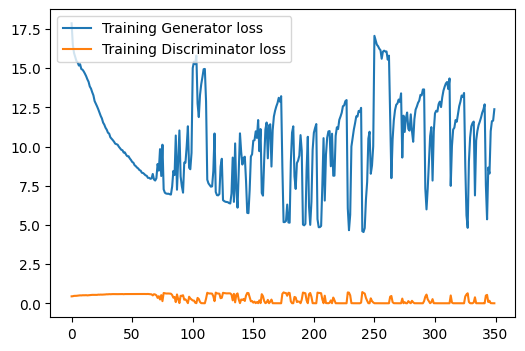

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(g_gen_losses, label="Training Generator loss")
plt.plot(g_disc_losses, label="Training Discriminator loss")
plt.legend()
plt.show()

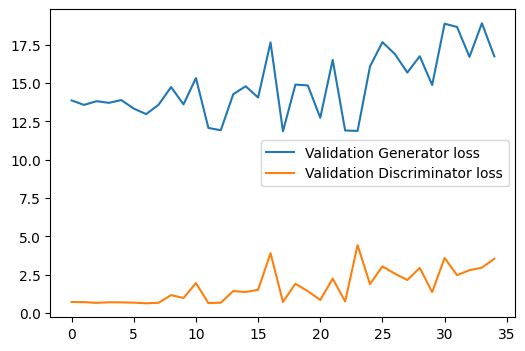

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(g_gen_losses_val, label="Validation Generator loss")
plt.plot(g_disc_losses_val, label="Validation Discriminator loss")
plt.legend()
plt.show()

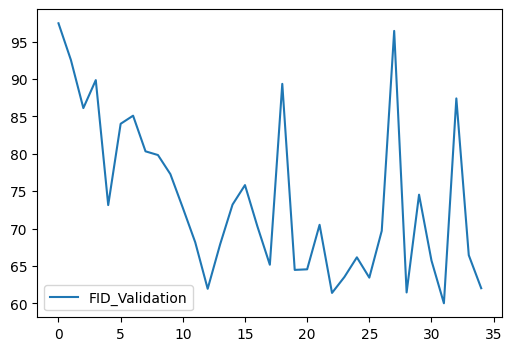

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(FID_val, label="FID_Validation")
plt.legend()
plt.show()

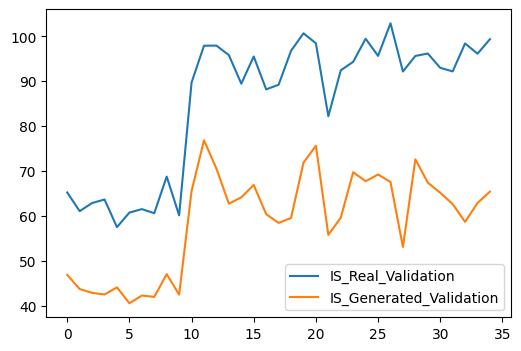

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(IS_real_val, label="IS_Real_Validation")
plt.plot(IS_generated_val, label="IS_Generated_Validation")
plt.legend()
plt.show()

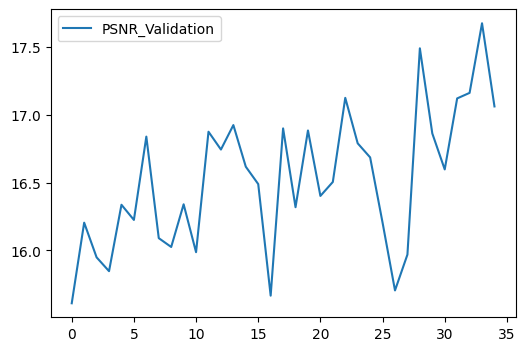

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(PSNR_val, label="PSNR_Validation")
plt.legend()
plt.show()

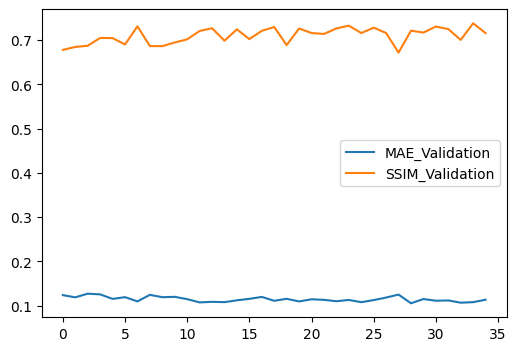

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(MAE_val, label="MAE_Validation")
plt.plot(SSIM_val, label="SSIM_Validation")
plt.legend()
plt.show()

#Evaluate on the Test Dataset


###Results at 100 epochs

In [ ]:
# Load network parameters
!cp "/content/drive/My Drive/gen_params1_PL_5K_350.pth" "gen_params1_PL_5K_350.pth"
gen.load_state_dict(torch.load('gen_params1_PL_5K_350.pth'))

!cp "/content/drive/My Drive/disc_params1_PL_5K_350.pth" "disc_params1_PL_5K_350.pth"
disc.load_state_dict(torch.load('disc_params1_PL_5K_350.pth'))

<All keys matched successfully>

####Evaluation Metrics

In [ ]:
#Calculate evaluation metrics

start = time.time()
gen_losses_test = []
disc_losses_test = []
g_FID = []
g_IS_real = []
g_IS_generated = []
g_PSNR = []
g_SSIM = []
g_MAE = []

for gray_image,colored_image in test_dataloader:

  original = colored_image.to(device)
  gray_image = gray_image.to(device)

  gen_loss, disc_loss = test_epoch(gray_image,original, gen, disc, BATCH_SIZE, device)

  gen_losses_test.append(gen_loss.detach().cpu())
  disc_losses_test.append(disc_loss.detach().cpu())

  predictions = gen(gray_image).detach().cpu()
  original = original.cpu()

  FID = calculate_fretchet(original,predictions, inceptionV3_model)

  IS_real = calculate_inception_score(original)
  IS_generated = calculate_inception_score(predictions)

  psnr_values, ssim_values = compute_psnr_ssim(original, predictions)

  mae_values = compute_mae(original, predictions)
  MAE = compute_average(mae_values)

  g_FID.append(FID)
  g_IS_real.append(IS_real)
  g_IS_generated.append(IS_generated)
  g_PSNR.append(np.mean(psnr_values))
  g_SSIM.append(np.mean(ssim_values))
  g_MAE.append(MAE)

print ('\nTime for testing is {} sec'.format(time.time()-start))

print('\t Test loss for Discriminator (single batch): %f' % (np.mean(disc_losses_test)))
print('\t Test loss for Generator (single batch): %f' % (np.mean(gen_losses_test)))

print("\n\t Test evaluation using FID for Test Dataset:", f"{np.mean(g_FID):.2f}")
print("\t Test evaluation using IS for Test Dataset for real images:", f"{np.mean(g_IS_real):.2f}")
print("\t Test evaluation using IS for Test Dataset for generated images:", f"{np.mean(g_IS_generated):.2f}")
print("\t Test evaluation using PSNR for Test Dataset:", f"{np.mean(g_PSNR):.2f}")
print("\t Test evaluation using SSIM for Test Dataset:", f"{np.mean(g_SSIM):.2f}")
print("\t Test evaluation using MAE for Test Dataset:",f"{np.mean(g_MAE):.2f}")

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Time for testing is 486.32357692718506 sec
	 Test loss for Discriminator (single batch): 3.610040
	 Test loss for Generator (single batch): 17.229782

	 Test evaluation using FID for Test Dataset: 85.92
	 Test evaluation using IS for Test Dataset for real images: 12.05
	 Test evaluation using IS for Test Dataset for generated images: 10.99
	 Test evaluation using PSNR for Test Dataset: 16.37
	 Test evaluation using SSIM for Test Dataset: 0.70
	 Test evaluation using MAE for Test Dataset: 0.12


####Some Plots

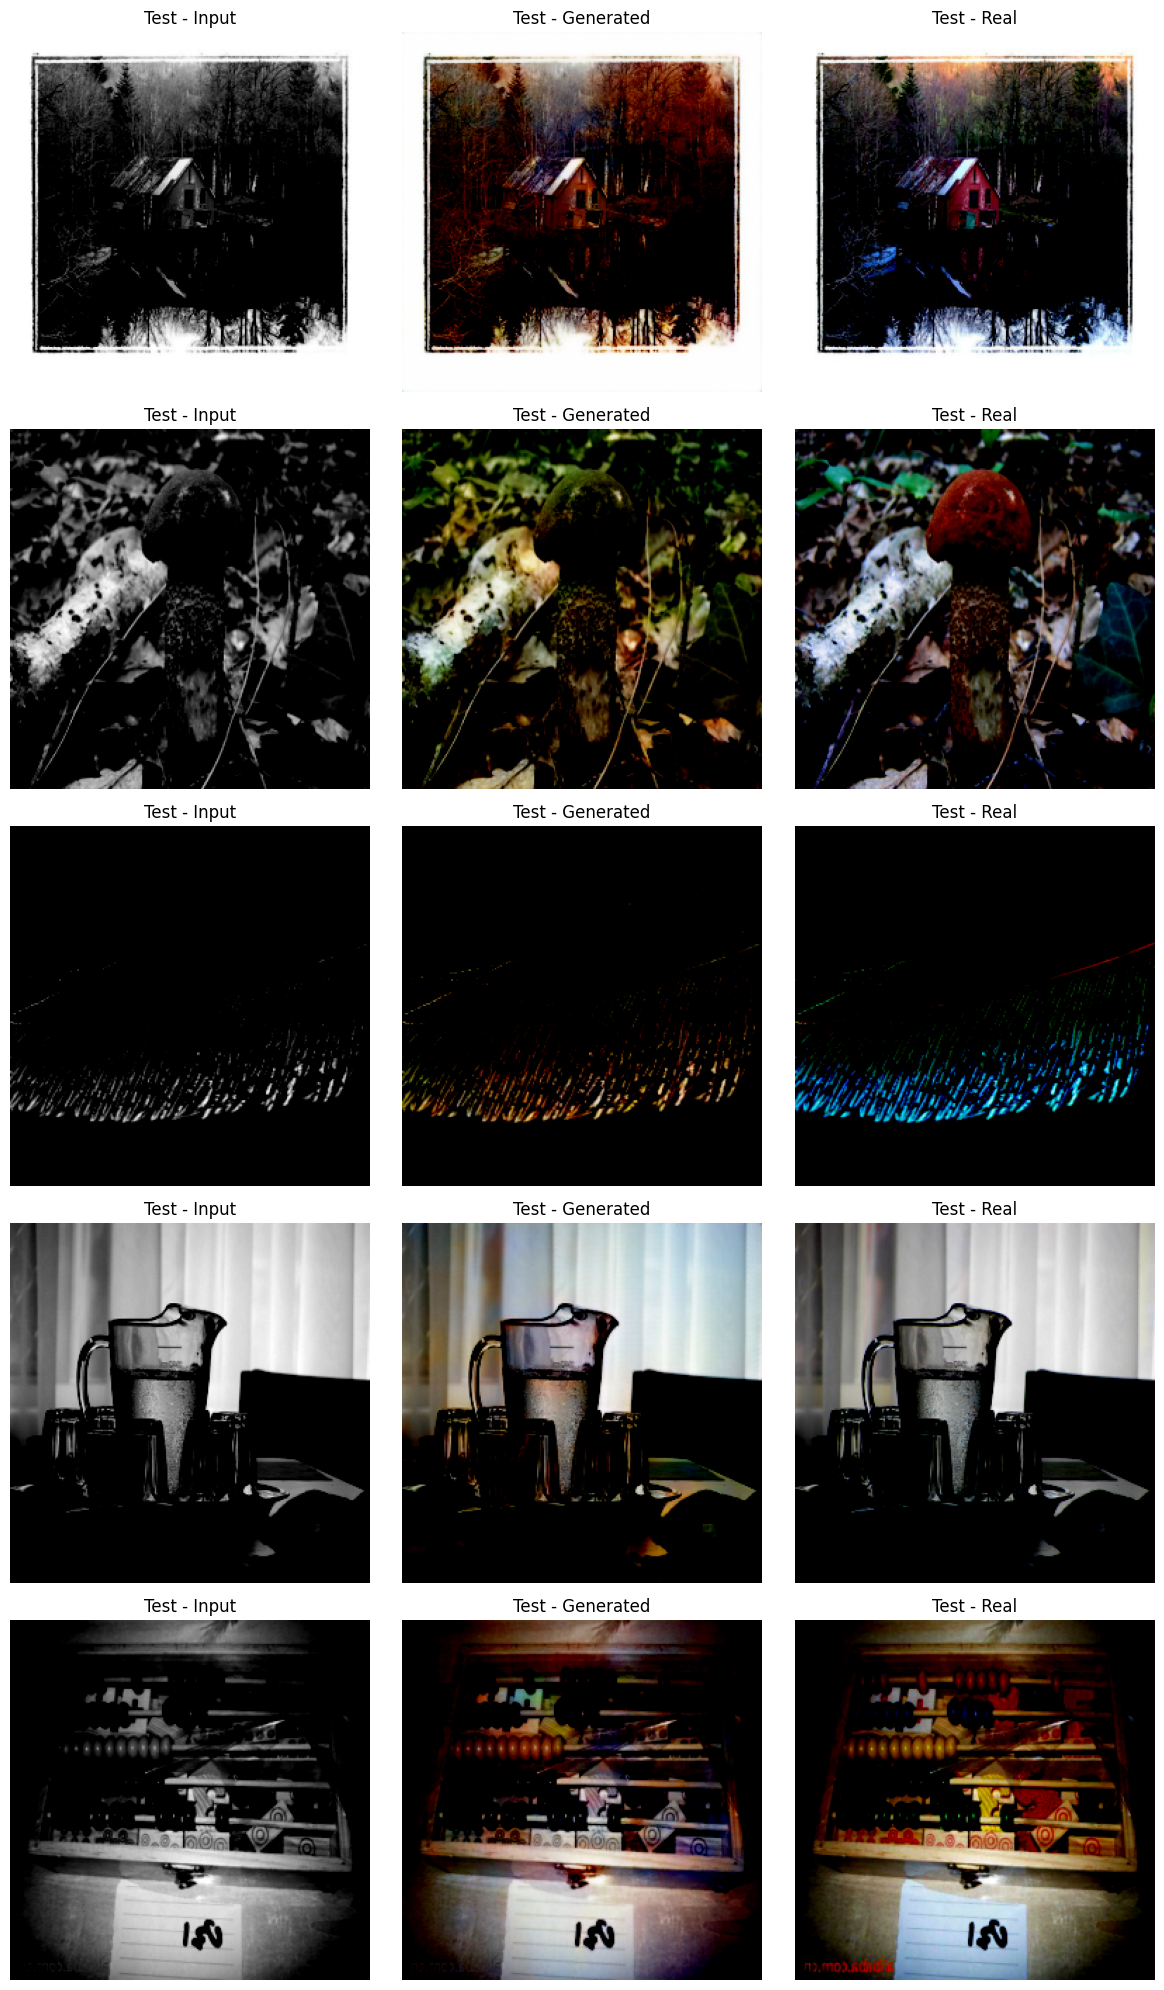

In [ ]:
# Plot some results on test dataset
image_inds = np.random.choice(test_dataset.__len__(), 5, replace=False)
lab_batch = torch.stack([test_dataset[i][0] for i in image_inds])
lab_batch = lab_batch.to(device)
original = torch.stack([test_dataset[i][1] for i in image_inds])

generate_and_save_images(gen, 100, lab_batch,original,"Test",num_of_rows=5)

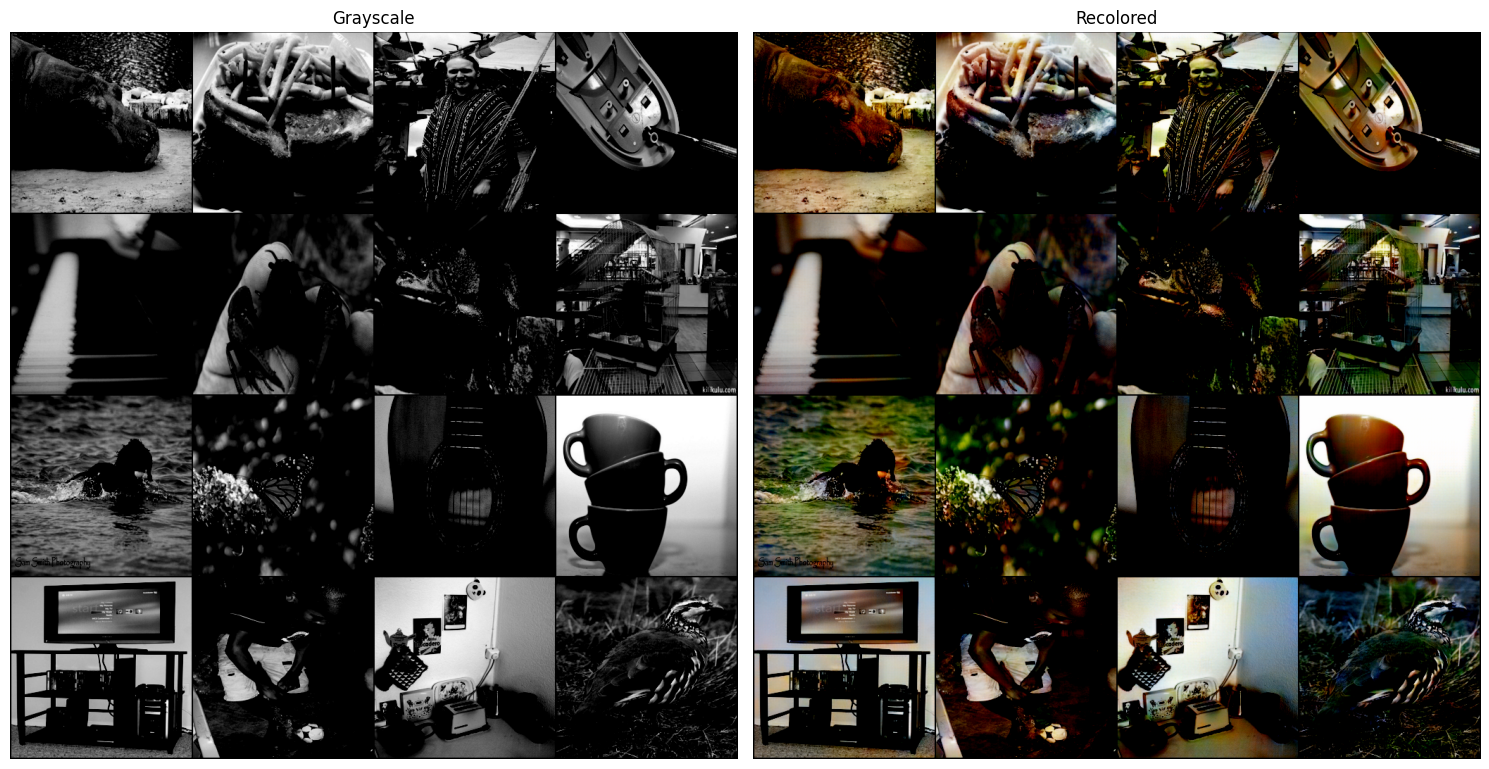

In [ ]:
#Show Random Re-Colored Images from the Test Set
gen.eval()
with torch.no_grad():

  image_inds = np.random.choice(test_dataset.__len__(), 16, replace=False)
  lab_batch = torch.stack([test_dataset[i][0] for i in image_inds])
  lab_batch = lab_batch.to(device)
  original = torch.stack([test_dataset[i][1] for i in image_inds])

  predictions = gen(lab_batch).detach().cpu()
  # plot images
  fig, ax = plt.subplots(figsize=(15, 15), nrows=1, ncols=2)
  ax[0].imshow(np.transpose(torchvision.utils.make_grid(np.clip(lab_batch.detach().cpu(), 0, 1), nrow=4).numpy(), (1, 2, 0)))
  ax[0].title.set_text('Grayscale')
  ax[0].axis('off')
  ax[1].imshow(np.transpose(torchvision.utils.make_grid(np.clip(predictions, 0 , 1), nrow=4).numpy(), (1, 2, 0)))
  ax[1].title.set_text('Recolored')
  ax[1].axis('off')

  plt.tight_layout()
  plt.show()